In [4]:
# fastai 0.7.0
!mkdir src -p && cd src && git clone https://github.com/fastai/fastai.git
!pip3 install -q bcolz graphviz sklearn_pandas isoweek pandas_summary ipywidgets torch torchvision torchtext

Cloning into 'fastai'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17292 (delta 3), reused 3 (delta 1), pack-reused 17279
Receiving objects: 100% (17292/17292), 304.60 MiB | 12.48 MiB/s, done.
Resolving deltas: 100% (11745/11745), done.
Checking out files: 100% (697/697), done.
tcmalloc: large alloc 1073750016 bytes == 0x58fb4000 @  0x7f9a96e642a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.1


(True, True)

In [3]:
import sys
sys.path.append("/content/src/fastai/old") # on windows use \'s instead
from fastai.conv_learner import *
from fastai.dataset import *
import gc
print(torch.__version__)
torch.backends.cudnn.benchmark=True
torch.cuda.is_available(), torch.backends.cudnn.enabled

0.4.1


(True, True)

In [0]:
!git config --global user.email 'nikshuang@163.com'
!git config --global user.name 'Alex Huang'
!pip install -q kaggle

In [0]:
PATH = Path('data/quick_draw')
TRN_TXT_PATH = PATH/'txt'
TRN_PATH = PATH/'train'
TEST_PATH = PATH/'test'
DISK_PATH = 'drive/quick_draw'
os.makedirs(DISK_PATH, exist_ok=True)
os.makedirs(PATH, exist_ok=True)
os.makedirs(TRN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(TRN_TXT_PATH, exist_ok=True)

In [8]:
!kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv -p {PATH}
!kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip -p {PATH}
!unzip -q {PATH}/train_simplified.zip -d {TRN_PATH}

 90% 53.0M/59.0M [00:00<00:00, 47.5MB/s]
100% 59.0M/59.0M [00:00<00:00, 77.4MB/s]
100% 7.37G/7.37G [01:52<00:00, 117MB/s]
100% 7.37G/7.37G [01:52<00:00, 70.3MB/s]
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


### Prepare data

In [16]:
%%time
def get_count(path): return (path.stem, pd.read_csv(path).shape[0])
with ThreadPoolExecutor(2) as e: counts = list(e.map(get_count, TRN_PATH.iterdir()))

CPU times: user 5min 58s, sys: 24.5 s, total: 6min 22s
Wall time: 5min 31s


In [0]:
counts = sorted(counts, key=lambda x: x[1])

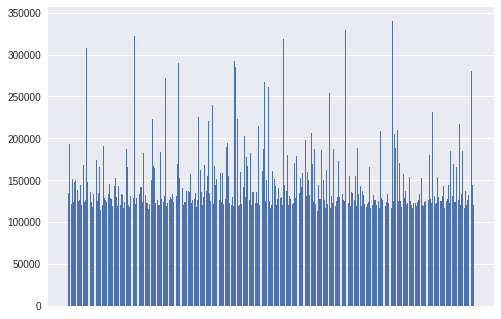

In [28]:
plt.bar([o[0] for o in counts], [o[1] for o in counts])
plt.xticks([])
fig = plt.gcf()

In [48]:
len(counts), counts[0], counts[-1], np.mean([o[1] for o in counts]).astype(np.int)

(340, ('panda', 113613), ('snowman', 340029), 146198)

In [43]:
df = pd.read_csv(TRN_PATH/'panda.csv')
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[132, 106, 81, 66, 40, 20, 18, 37, 60, 72, 1...",5453565080371200,True,2017-03-13 16:53:48.790980,panda
1,BR,"[[[90, 72, 50, 17, 6, 0, 0, 4, 48, 136, 161, 2...",5965556941324288,False,2017-03-09 16:19:44.633780,panda
2,BR,"[[[185, 148, 133, 116, 97, 61, 34, 34, 45, 57,...",6307234680143872,True,2017-01-26 00:21:17.363700,panda
3,US,"[[[149, 122, 97, 72, 59, 35, 26, 18, 17, 21, 2...",4625715938983936,True,2017-03-23 17:55:31.427700,panda
4,US,"[[[110, 63, 45, 30, 9, 1, 1, 15, 30, 59, 94, 1...",5116330174840832,True,2017-01-26 16:13:48.454190,panda


In [41]:
df2 = pd.read_csv(PATH/'test_simplified.csv')
df2.head()

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


In [0]:
# https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892
BASE_SIZE = 256

def draw_cv2(raw_strokes, size=128, lw=6, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    img = cv2.copyMakeBorder(img, 4, 4, 4, 4, cv2.BORDER_CONSTANT)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return img

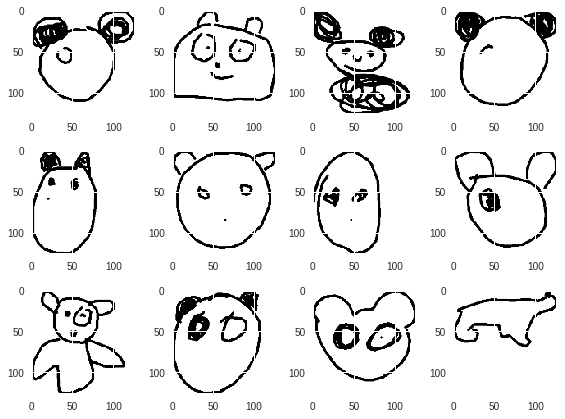

In [68]:
fig, axes = plt.subplots(3, 4, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(draw_cv2(eval(df.loc[i, 'drawing'])))
plt.tight_layout()

In [0]:
r = 0.01  # a total of about 500k images
k = 1500  # a total of 510k images
sz = 128
mn = f'mobilenet_{sz}sz_{k}'
dn = f'quickdraw_data_{sz}sz_{k}.tar.bz2'
FN_PKL = f'fnames_{sz}sz_{k}.pkl'
VAL_PKL = f'val_idxs_{sz}sz_{k}.pkl'

In [0]:
def df_to_ims(path):
    df = pd.read_csv(path, nrows=k)
    kids = df.key_id.values
    drawings = df.drawing.values
    words = np.array(['_'.join(o.split()) for o in df.word.values])
    for kid, drawing, word in zip(kids, drawings, words):
        img = draw_cv2(eval(drawing), size=sz)
        img_rgb = np.repeat(img[:, :, None], 3, -1)
        fpth = PATH/f'train_{sz}/{word}/{kid}.png'
        os.makedirs(str(fpth.parent), exist_ok=True)
        plt.imsave(str(fpth), img_rgb)

In [0]:
df_to_ims(TRN_PATH/'apple.csv')

In [71]:
!ls {PATH}/train_128/apple | head -3

4504363701633024.png
4505040377085952.png
4505772249579520.png


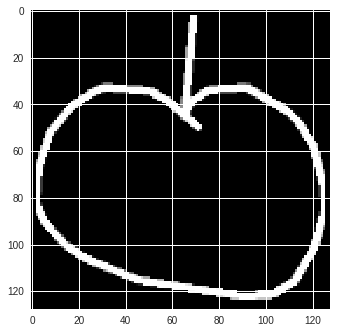

In [77]:
img = plt.imread(str(PATH/'train_128/apple/4505772249579520.png'))
plt.imshow(img)

In [78]:
%%time
shutil.rmtree(PATH/f'train_{sz}', ignore_errors=True)
os.makedirs(PATH/f'train_{sz}', exist_ok=True)
with ThreadPoolExecutor(2) as e: e.map(df_to_ims, TRN_PATH.iterdir())

CPU times: user 31min 20s, sys: 2min 56s, total: 34min 17s
Wall time: 25min 32s


In [0]:
def test_df_to_ims(path):
    df = pd.read_csv(path)
    kids = df.key_id.values
    drawings = df.drawing.values
    for kid, drawing in zip(kids, drawings):
        img = draw_cv2(eval(drawing), size=sz)
        img_rgb = np.repeat(img[:, :, None], 3, -1)
        plt.imsave(str(PATH/f'test_{sz}/{kid}.png'), img_rgb)

In [80]:
%%time
shutil.rmtree(PATH/f'test_{sz}', ignore_errors=True)
os.makedirs(PATH/f'test_{sz}', exist_ok=True)
test_df_to_ims(PATH/'test_simplified.csv')

CPU times: user 5min 6s, sys: 8.01 s, total: 5min 14s
Wall time: 5min 15s


In [81]:
!ls {PATH}/test_128 | head -3

9000003627287624.png
9000010688666847.png
9000023642890129.png


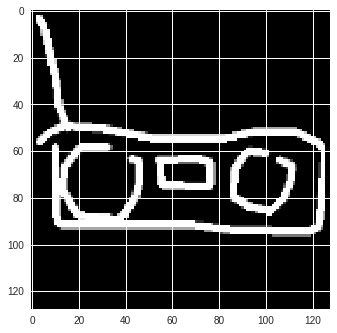

In [82]:
img = plt.imread(str(PATH/'test_128/9000003627287624.png'))
plt.imshow(img)

In [94]:
def get_image_files(path, recurse=True):
  return [o for o in Path(path).glob('**/*' if recurse else '*')
          if not o.name.startswith('.') and not o.is_dir() and o.suffix == '.png']

fnames = get_image_files(PATH/f'train_{sz}')
val_idxs = get_cv_idxs(len(fnames))
len(val_idxs), val_idxs[:2], len(fnames), fnames[:3]

(102000,
 array([108961, 115875]),
 510000,
 [PosixPath('data/quick_draw/train_128/zigzag/4559797904998400.png'),
  PosixPath('data/quick_draw/train_128/zigzag/4612714536108032.png'),
  PosixPath('data/quick_draw/train_128/zigzag/5128690734202880.png')])

In [100]:
fnames[0].parent.stem

'zigzag'

In [0]:
fns = np.array(['/'.join(o.parts[-2:]) for o in fnames])
labels = np.array([o.parent.stem for o in fnames])
df = pd.DataFrame({'fname': fns, 'word': labels})
df.to_csv(PATH/'train.csv', index=False)

In [102]:
df = pd.read_csv(PATH/'train.csv')
df.head()

,fname,word
0,zigzag/4559797904998400.png,zigzag
1,zigzag/4612714536108032.png,zigzag
2,zigzag/5128690734202880.png,zigzag
3,zigzag/6520470406955008.png,zigzag
4,zigzag/5122774639050752.png,zigzag


In [103]:
with open(FN_PKL, 'wb') as fp:
  pickle.dump(fnames, fp)
with open(VAL_PKL, 'wb') as fp:
  pickle.dump(val_idxs, fp)
shutil.copy(f'{FN_PKL}', DISK_PATH)
shutil.copy(f'{VAL_PKL}', DISK_PATH)
shutil.copy(PATH/'train.csv', DISK_PATH)

'drive/quick_draw/train.csv'

In [0]:
val_idxs = pickle.load(open('val_idxs_128sz_1500.pkl', 'rb'))

### Dataset

In [9]:
arch = resnet34
sz = 128
bs = 128

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on)
md = ImageClassifierData.from_csv(PATH, f'train_{sz}', PATH/'train.csv', bs=bs, tfms=tfms,
                                  val_idxs=val_idxs, test_name=f'test_{sz}')
md.c, md.classes[:3]

(340, ['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa'])

### MobileNet

In [0]:
def std_conv(nin, nf, ks=3, stride=1):
  return nn.Sequential(
      nn.Conv2d(nin, nf, ks, stride, padding=ks//2, bias=False),
      nn.BatchNorm2d(nf),
      nn.ReLU(inplace=True)
  )

def conv_dw(nin, nf, stride=2):
  return nn.Sequential(
      nn.Conv2d(nin, nin, 3, stride, 1, groups=nin, bias=False),
      nn.BatchNorm2d(nin),
      nn.ReLU(inplace=True),
      nn.Conv2d(nin, nf, 1, 1, bias=False),
      nn.BatchNorm2d(nf),
      nn.ReLU(inplace=True)
  )

class MobileNet(nn.Module):
  def __init__(self, num_classes, ps=0.25):
    super().__init__()
    self.layers = nn.Sequential(
        std_conv(3, 32, 2),
        conv_dw(32, 64, 1),
        conv_dw(64, 128),
        conv_dw(128, 128, 1),
        conv_dw(128, 256),
        conv_dw(256, 256, 1),
        conv_dw(256, 512),
        conv_dw(512, 256, 1),   # bottleneck
        conv_dw(256, 512, 1),
#         conv_dw(512, 512, 1),
#         conv_dw(512, 512, 1),
#         conv_dw(512, 512, 1),
#         conv_dw(512, 512, 1),
#         conv_dw(512, 512, 1),
#         conv_dw(512, 1024, 2),
#         conv_dw(1024, 1024, 1),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.BatchNorm1d(512),
        nn.Dropout(p=ps),
        nn.Linear(512, num_classes),      
        nn.LogSoftmax()
    )

  def forward(self, x):
    return self.layers(x)

In [0]:
def map_top3(preds, targs):
  top3 = torch.sort(preds, dim=1, descending=True)[0][:, :3]
  return torch.mean(torch.sum(torch.exp(top3), 1))

In [0]:
m = to_gpu(MobileNet(md.c))
learn = ConvLearner.from_model_data(m, md)
learn.opt_fn = optim.Adam
learn.metrics = [accuracy, map_top3]

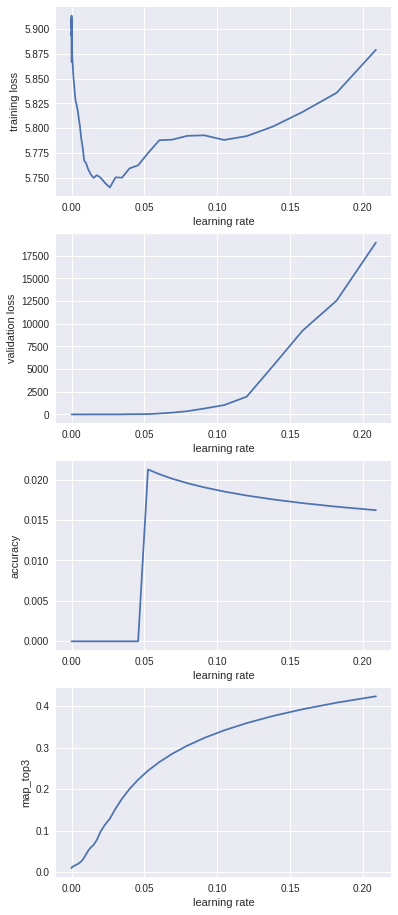

In [16]:
learn.lr_find2(num_it=100)
learn.sched.plot(0, 10)

In [0]:
lr = 2e-2
learn.fit(lr, 1, cycle_len=10, use_clr=(20, 10))
learn.save(f'mobilenet_{sz}sz_{k}')

epoch      trn_loss   val_loss   accuracy   map_top3   
    0      4.221134   3.929499   0.174265   0.373     
    1      3.122172   2.83353    0.352059   0.528392  
    2      2.647427   2.299856   0.460735   0.640049  
    3      2.421247   2.322631   0.454706   0.634115  
    4      2.163204   1.90709    0.545147   0.721836  
    5      1.975682   1.765632   0.575662   0.747461  
    6      1.821589   1.665574   0.603162   0.768702  
    7      1.698267   1.60571    0.617794   0.786565  
    8      1.58901    1.53894    0.634118   0.807489  
    9      1.459088   1.491365   0.644044   0.82133   


### Submission

In [0]:
preds = learn.TTA(is_test=True)[0]

In [0]:
preds.shape

(5, 112199, 340)

In [0]:
pr = np.mean(np.exp(preds), 0)
pr.shape

(112199, 340)

In [0]:
top_3 = np.argsort(pr)[:, ::-1][:, :3]
cat = np.array([' '.join(str(md.classes[i]) for i in o) for o in top_3])
image = md.test_ds.fnames

In [0]:
submission = pd.DataFrame({'key_id': image, 'word': cat})
submission.head()

,key_id,word
0,test_128/9028014602137518.png,banana elbow matches
1,test_128/9325698402591604.png,paint_can hot_tub cake
2,test_128/9791244567109262.png,string_bean feather dolphin
3,test_128/9396277400422292.png,bulldozer tractor car
4,test_128/9037773561277176.png,flamingo giraffe saxophone


In [0]:
submission.key_id = submission.key_id.str.replace('^test_128/', '')
submission.key_id = submission.key_id.str.replace('.png$', '')
submission.head()

,key_id,word
0,9028014602137518,banana elbow matches
1,9325698402591604,paint_can hot_tub cake
2,9791244567109262,string_bean feather dolphin
3,9396277400422292,bulldozer tractor car
4,9037773561277176,flamingo giraffe saxophone


In [0]:
submission.to_csv('submission.csv.gz', index=False, compression='gzip')